# Exploratory Analysis of Parsed Data

<a id="table-of-contents"></a>

## Table of Contents

This notebook is organized into checks and explorations that will inform data cleaning.

0. [**Intro**](#intro)
   * Overview
   * Set configurations
   * Load data

1. [**High-Level Checks**](#data_checks)  
   * Record counts vs. expectations  
   * Date field validation  
   * Time distribution visualization  

2. [**Repeated Headlines**](#headlines)  
   * Most frequently occurring headlines  
   * Headlines with moderate repetition  

3. [**Duplicate and Near-Duplicate Articles**](#duplicates)  
   * Exact duplicates  
   * Near-duplicate titles  
   * Near-duplicate articles (identical standardized title, similar body text)  

4. [**Potential Issues**](#issues)  
   * Review of working-class keyword coverage  
   * Additional patterns in titles
   * Other obervations
   
5. [**Conclusion**](#conclusion)
5. [**Next Steps**](#next_steps)

__To do:__


* Clarifications to new questions around stop words

* See other questions.

* Clean-up part at the end

* see "temp" / "to do" / "todo" items and finalize.

* Add Burui's analysis, and add Guo's to next notebook

* Peer review of notebook


<a id="intro"></a>

## 0. Intro


[⬆ Return to Top](#table-of-contents)

### Overview

This notebook investigates the parsed dataset to:

* **Validate parsing accuracy** – confirm that the parsing process worked as intended, or identify issues that require correction.  
* **Inform data cleaning steps** – understand the dataset's structure and characteristics to guide data cleaning steps before downstream analysis.

### Set configurations

Toggle example display in output cells.
* True  = Show example articles (helpful for decision-making phase)
* False = Hide examples (cleaner view for high-level review)

In [27]:
SHOW_EXAMPLE_ARTICLES = False

### Load packages and data

In [28]:
import sys
import os
import pandas as pd
from ftfy import fix_text
import re
import time
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [29]:
# Add parent directory to sys.path to import local scripts
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()))))

from data_preparation.utils import standardize_text, obtain_similarity_dictionary, create_date_components, add_duplicate_flags, compute_similarity

In [30]:
df_articles = pd.read_pickle("../data/processed/parsed_articles.pkl")

<a id="data_checks"></a>
## 1. High Level Checks 


[⬆ Return to Top](#table-of-contents)

This section performs high-level checks on the dataset to ensure fundamental data quality and validity.

### Record Counts

In [31]:
expected_n_articles = 500 * 86 + 305 + 361
parsed_articles = df_articles.shape[0]

In [32]:
try:
    assert expected_n_articles == parsed_articles, (
        f"Mismatch: expected {expected_n_articles}, got {parsed_articles}"
    )
    print(f"✅ Total number of articles parsed: {parsed_articles} — matches expectations.")
except AssertionError as e:
    print(f"❌ There's a mismatch. {e}")


✅ Total number of articles parsed: 43666 — matches expectations.


In [33]:
expected_n_source_files = 88
parsed_sources_files = len(set(df_articles["source_file"]))

In [34]:
try:
    assert expected_n_source_files == parsed_sources_files, (
        f"Mismatch: expected {expected_n_source_files}, got {parsed_sources_files}"
    )
    print(f"✅ Total number of source files parsed: {parsed_sources_files} — matches expectations.")
except AssertionError as e:
    print(f"❌ There's a mismatch. {e}")


✅ Total number of source files parsed: 88 — matches expectations.


### Check dates

In [35]:
# Check that no date values are missing
missing_dates_count = df_articles['date'].isna().sum()
try:
    assert missing_dates_count == 0, (
        f"Found {missing_dates_count} articles with missing dates:\n"
        f"{df_articles.loc[df_articles['date'].isna()]}"
    )
    print("✅ All articles have a date — expectations met.")
except AssertionError as e:
    print(f"❌ Date check failed. {e}")


✅ All articles have a date — expectations met.


In [36]:
# Validate that all 'date' entries can be parsed into valid dates
try:
    parsed_dates = pd.to_datetime(df_articles["date"], errors="coerce").dt.date
    invalid_dates = df_articles.loc[parsed_dates.isna()]
    invalid_count = invalid_dates.shape[0]

    assert invalid_count == 0, (
        f"Found {invalid_count} articles with invalid or missing dates:\n"
        f"{invalid_dates}"
    )

    print("✅ All articles have valid dates — expectations met.")
except AssertionError as e:
    print(f"❌ Date validation failed. {e}")


✅ All articles have valid dates — expectations met.


In [37]:
print("Number of articles with date at the end: ", 
int(df_articles.apply(lambda x: x['correction_appended'] or x['load_date_at_end'], axis = 1).sum()))

Number of articles with date at the end:  461


### Time Distribution Plot

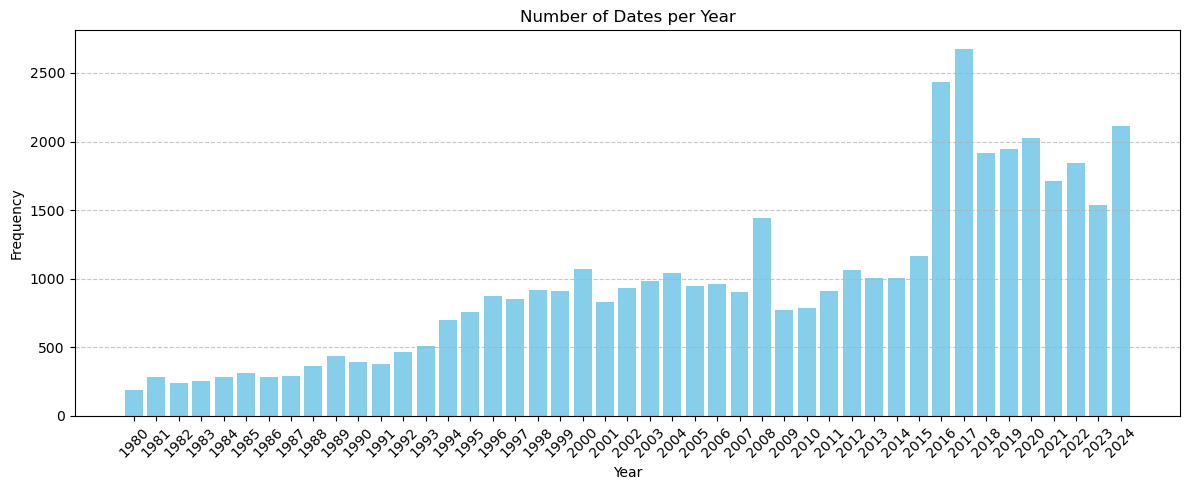

In [38]:
# Group by year
years = [d.year for d in parsed_dates]
year_counts = Counter(years)

# Sort by year
sorted_years = sorted(year_counts)
frequencies = [year_counts[year] for year in sorted_years]

# Plot
plt.figure(figsize=(12, 5))
plt.bar(sorted_years, frequencies, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Number of Dates per Year')
plt.xticks(sorted_years, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<a id="headlines"></a>
## 2. Recurring Headlines

[⬆ Return to Top](#table-of-contents)

This section examines headlines that appear repeatedly in the dataset to identify patterns that may require attention. It is divided into two categories: __most frequent headlines__ and __medium-frequency headlines__.

For each recurring headline, we manually review a sample to identify underlying patterns and decide on appropriate data-cleaning actions. Although we apply the same review process to both categories, we present them separately because they tend to exhibit distinct patterns.


### Most frequent headlines

In [39]:
highest_frequency_titles = {key:int(value) for key, value in dict(df_articles['title'].value_counts()).items() if value > 110}
highest_frequency_titles

{'No Headline In Original': 368}

In [40]:
df_no_headline = df_articles.loc[df_articles["title"] == "No Headline In Original"]
df_no_headline.head(2)

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file
446,No Headline In Original,The New York Times,2024-09-01,Section MB; Column 0; Metropolitan Desk; Pg. 3...,533 words,"\n\nIn the Schools: Dress Codes, Self-Expressi...",False,False,NYT/55.DOCX
457,No Headline In Original,The New York Times,2022-01-30,Section MB; Column 0; Metropolitan Desk; Pg. 3...,774 words,"\n\nHow Fire Defined the Bronx, and Us\nReader...",False,False,NYT/55.DOCX


In [41]:
select_index = 0 # change index to view the body of a different article
if SHOW_EXAMPLE_ARTICLES:
    print(df_no_headline['body'].iloc[select_index])

In [42]:
# Example from other publishers
select_index = 0 # change index to view the body of a different article
select_publisher = "Chicago Daily Herald" # change publisher name to view a different example
if SHOW_EXAMPLE_ARTICLES:
    df_no_headline_select_publisher = df_no_headline.loc[df_no_headline["publisher"] == "Chicago Daily Herald"]
    print(df_no_headline_select_publisher['body'].iloc[select_index])

__Observation:__ A manual review of a sample of articles titled "No Headline In Original" reveals that the original source data contains this exact title, confirming it is not a parsing error. In most cases, the article body consists of multiple readers’ notes to the editor, each with its own heading; however, there are exceptions to this pattern.

__Decision:__ During data cleaning, separate readers’ notes to the editor from the main dataset to enable independent analysis.


### Medium-frequency headlines

In [43]:
# Repeated titles
{key: int(value) for key, value in dict(df_articles["title"].value_counts()).items() if value > 20 and value < 115}

{'Movie guide': 101,
 'Movie Guide': 36,
 'New & Noteworthy Paperbacks': 36,
 'Letters to the Editor': 34,
 'MOVIE GUIDE': 33,
 'Paperback Row': 30,
 'inside track': 28,
 'Readers Write': 27,
 'Art': 27,
 'Four stars: superior. Three stars: good. Two stars: average. One star: poor. D (': 25,
 'Marco Rubio; REPUBLICAN': 24}

In [44]:
select_title = "MOVIE GUIDE" # select title
select_index = 0 # select index
if SHOW_EXAMPLE_ARTICLES:
    print(df_articles.loc[df_articles["title"] == select_title]["body"].iloc[select_index])

__Observation:__ We manually reviewed a selection of articles for each frequently repeated title and found that they fell into two main groups:

1. Not relevant for our analysis: These articles typically consist of recurring lists or recommendations related to movies, books, and the arts, accompanied by only brief descriptions. Given the limited depth of information, we determined they do not meet the requirements for our analysis.

    __Decision__: Filter out these articles.

    __Applies to__: Articles with titles "New & Noteworthy Paperbacks", "Paperback Row", "Art", "Four stars: superior. Three stars: good. Two stars: average. One star: poor. D (", "Movie guide", "MOVIE GUIDE".


2. Readers’ notes to the editor: These articles, including Letters to the Editor and Readers Write, document conversations between readers and the publication. While not all are directly related to the working-class, the presence of at least one working-class keyword in a set of reader responses qualified the entire set for inclusion.

    __Decision:__ Keep these articles, but store them separately from the main dataset for independent study.

    __Applies to:__ Articles titled 'Letters to the Editor' and "Readers Write"

### Recurring patterns within headlines

In [45]:
# @Burui: Please add your analysis for articles starting with "Best Sellers:" or similar "xxx: yyy" patterns. 
# Also review the related observations and decisions listed below.

In [51]:
# Part 1: Basic Topic Pattern Identification
def identify_topic_specific_titles(df):
    """
    Identify all titles following "topic:specific_info" pattern
    """
    pattern = r'^[A-Za-z\s]+:\s+'
    topic_articles = df[df['title'].str.match(pattern, na=False)]
    return topic_articles

# Identify topic articles
topic_articles = identify_topic_specific_titles(df_articles)
print(f"Found {len(topic_articles)} articles with 'topic:info' format")

topics = topic_articles['title'].str.extract(r'^([^:]+):')[0].value_counts()
print("\nTopic type distribution:")
print(topics.head(15))

Found 2880 articles with 'topic:info' format

Topic type distribution:
0
Best Sellers           225
Review                 120
NEIGHBORHOOD REPORT     92
The Listings            63
Transcript              51
Four stars              31
STAGE                   29
THEATER                 26
POLITICS                25
Commentary              20
Kevin Riordan           17
Editorial               15
THE WAY WE LIVE NOW     15
Movies                  15
FILM                    15
Name: count, dtype: int64


In [55]:
# Part 2: Content Analysis of Topic-Specific Coverage
def analyze_working_class_presence(articles_subset, subset_name):
    print(f"\n=== {subset_name} Analysis ===")
    
    working_class_keywords = ['working-class', 'working class', 'blue collar', 'labor', 'workers']
    keyword_locations = {}
    
    for keyword in working_class_keywords:
        locations = {}
        for field in ['title', 'body', 'section']:
            if field in articles_subset.columns:
                matches = articles_subset[field].str.contains(keyword, case=False, na=False).sum()
                if matches > 0:
                    locations[field] = matches
        
        if locations:
            keyword_locations[keyword] = locations
    
    if keyword_locations:
        print("Working-class keywords found:")
        for keyword, locations in keyword_locations.items():
            location_str = ", ".join([f"{field}: {count}" for field, count in locations.items()])
            print(f"  '{keyword}' - {location_str}")
    else:
        print("No working-class keywords found")
    
    if 'length' in articles_subset.columns:
        valid_lengths = []
        for length_val in articles_subset['length'].dropna():
            if isinstance(length_val, str):
                import re
                numbers = re.findall(r'(\d+)\s*words', str(length_val))
                valid_lengths.extend([int(num) for num in numbers])
            elif isinstance(length_val, (int, float)) and not pd.isna(length_val):
                valid_lengths.append(length_val)
        
        if valid_lengths:
            avg_length = sum(valid_lengths) / len(valid_lengths)
            print(f"Average length: {avg_length:.0f} words")
            print(f"Length range: {min(valid_lengths):.0f}-{max(valid_lengths):.0f} words")
            print(f"Total articles with length data: {len(valid_lengths)}")
        else:
            print("No valid length data available")
    else:
        print("No length column found")
    
    return keyword_locations

def identify_topic_specific_titles(df_articles):
    pattern = r'^[A-Za-z\s]+:\s+'
    topic_articles = df_articles[df_articles['title'].str.match(pattern, na=False)]
    return topic_articles

topic_articles = identify_topic_specific_titles(df_articles)
topic_articles_copy = topic_articles.copy()
topic_articles_copy['topic_type'] = topic_articles_copy['title'].str.extract(r'^([^:]+):')[0]

best_sellers = df_articles[df_articles['title'].str.startswith('Best Sellers:', na=False)]
best_sellers_keywords = analyze_working_class_presence(best_sellers, "Best Sellers Articles")

other_topics = topic_articles[~topic_articles['title'].str.startswith('Best Sellers:', na=False)]
if len(other_topics) > 0:
    other_keywords = analyze_working_class_presence(other_topics, "Other Topic Articles")

top_topics = topic_articles_copy['topic_type'].value_counts().head(10)
print(f"\n{'='*60}")
print("DETAILED ANALYSIS BY TOPIC TYPE")
print(f"{'='*60}")
for topic_name, count in top_topics.items():
    topic_subset = topic_articles_copy[topic_articles_copy['topic_type'] == topic_name]
    analyze_working_class_presence(topic_subset, f"{topic_name} ({count} articles)")


=== Best Sellers Articles Analysis ===
No working-class keywords found
Average length: 513 words
Length range: 420-717 words
Total articles with length data: 225

=== Other Topic Articles Analysis ===
Working-class keywords found:
  'working-class' - title: 18, body: 2075
  'working class' - title: 17, body: 698
  'blue collar' - title: 1, body: 24
  'labor' - title: 17, body: 636
  'workers' - title: 16, body: 549
Average length: 1570 words
Length range: 1-22316 words
Total articles with length data: 2655

DETAILED ANALYSIS BY TOPIC TYPE

=== Best Sellers (225 articles) Analysis ===
No working-class keywords found
Average length: 513 words
Length range: 420-717 words
Total articles with length data: 225

=== Review (120 articles) Analysis ===
Working-class keywords found:
  'working-class' - title: 5, body: 105
  'working class' - body: 17
  'blue collar' - body: 1
  'labor' - title: 2, body: 23
  'workers' - body: 9
Average length: 724 words
Length range: 265-1495 words
Total articl

In [58]:
# Part 3: Context Examples (Only shown when SHOW_EXAMPLE_ARTICLES = True)
def show_keyword_context_sample(articles_subset, topic_name, max_examples=1):
    if not SHOW_EXAMPLE_ARTICLES:
        return
        
    working_class_keywords = ['working-class', 'working class']
    
    print(f"\n{'='*50}")
    print(f"CONTEXT EXAMPLES: {topic_name}")
    print(f"{'='*50}")
    
    found_examples = False
    
    for keyword in working_class_keywords:
        mask = articles_subset['body'].str.contains(keyword, case=False, na=False)
        keyword_articles = articles_subset[mask]
        
        if len(keyword_articles) > 0 and not found_examples:
            found_examples = True
            
            for idx, (_, article) in enumerate(keyword_articles.head(max_examples).iterrows()):
                body = str(article['body'])
                sentences = re.split(r'[.!?]+', body)
                relevant_sentences = []
                
                for sentence in sentences:
                    if keyword.lower() in sentence.lower():
                        sentence = sentence.strip()
                        if len(sentence) > 20:
                            relevant_sentences.append(sentence)
                
                if relevant_sentences:
                    print(f"\nArticle: {article['title'][:60]}...")
                    print(f"Publisher: {article['publisher']}")
                    print(f"Date: {article['date']}")
                    print("Context sentences:")
                    
                    for sent_idx, sentence in enumerate(relevant_sentences[:2]):
                        if len(sentence) > 300:
                            displayed_sentence = sentence[:300] + "..."
                        else:
                            displayed_sentence = sentence
                        print(f"  {sent_idx+1}. {displayed_sentence}")
                    
                    if len(relevant_sentences) > 2:
                        print(f"  ... and {len(relevant_sentences)-2} more sentences with '{keyword}'")
                    break
    
    if not found_examples and SHOW_EXAMPLE_ARTICLES:
        print("No examples with working-class keywords found in this topic category.")

topic_name = "Best Sellers" 
if topic_name in topic_articles_copy['topic_type'].values:
    topic_subset = topic_articles_copy[topic_articles_copy['topic_type'] == topic_name]
    show_keyword_context_sample(topic_subset, topic_name)

**Observation:** Articles with titles starting with "Best Sellers:" or "Four Stars:" contain general lists and recommendations.  

**Decision:** Filter out articles with titles starting with "Best Sellers:" or "Four Stars:", consistent with the earlier decision to remove recurring lists and recommendation pieces.  


<a id="duplicates"></a>

## 3. Duplicates and Near-Dupplicates

[⬆ Return to Top](#table-of-contents)

This section examines exact duplicates and near-duplicates in the dataset.

We begin by **cleaning the text data** and **removing exact duplicates**, recording the number of dropped rows.

Next, we analyze **similarity scores for titles** to explore opportunities for further standardization.  
> *Note:* The *standardized title* field is used only for grouping articles in the next stage. We do **not** deduplicate based on standardized title alone. Deduplication requires considering both title and body content.

We then analyze **similarity scores for article bodies** within each group of matching standardized titles. Three thresholds are tested—**90%**, **95%**, and **98%**—to determine the most appropriate cutoff for identifying near-duplicates.

Final deduplication is performed when:  
1. The standardized titles match, **and**  
2. The body similarity score meets or exceeds the chosen threshold.

### Clean-text data and remove exact duplicates

In [19]:
# clean data
df_articles['body'] = df_articles['body'].apply(fix_text)
df_articles['title'] = df_articles['title'].apply(fix_text)

# standardize titles
df_articles['title_stand'] = df_articles['title'].apply(standardize_text)

In [20]:
# 1. Shuffle the DataFrame
df_articles = df_articles.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Deduplicate while keeping earliest date 
before_n = df_articles.shape[0]
df_articles = (
    df_articles
    .sort_values(by='date', ascending=True)
    .drop_duplicates(subset=["body", "title_stand"], keep='first')
)

after_n = df_articles.shape[0]

# 3. Sort final DataFrame by date from latest to earliest
df_articles = df_articles.sort_values(by='date', ascending=False).reset_index(drop=True)

print(f"Number of dropped duplicates: {before_n - after_n}.")

Number of dropped duplicates: 314.


### Analyzing similarity scores for non-identical titles

In [21]:
similar_dict_path = "../data/processed/similar_dict_75.pkl"

if os.path.exists(similar_dict_path):
    # Load dictionary from pickle file
    with open(similar_dict_path, "rb") as f:
        similar_dict = pickle.load(f)
else:   
    threshold = .75
    titles = list(set(df_articles['title_stand']))
    print(f"Start similarity comparison with {threshold} threshold.")
    start_time = time.time()
    similar_dict = obtain_similarity_dictionary(titles, threshold)
    end_time = time.time()
    print(f"Elapsed time: {(end_time - start_time) / 60:.4f} minutes")
    
    # Save dictionary to a pickle file
    with open(similar_dict_path, "wb") as f:
        pickle.dump(similar_dict, f)

In [22]:
stand_text1 = list(similar_dict.keys())[0]
title1 = df_articles.loc[df_articles['title_stand'] == stand_text1]['title'].iloc[0]

stand_text2 = similar_dict[list(similar_dict.keys())[0]][0][0]
title2 = df_articles.loc[df_articles['title_stand'] == stand_text2]['title'].iloc[0]

print(f"Matching headlines example:\n\t{title1}\n\t{title2}")
print(f"\nStandardized versions:\n\t{stand_text1}\n\t{stand_text2}")
print("\nSimilarity score: ", similar_dict[list(similar_dict.keys())[0]][0][1])

Matching headlines example:
	Taking On Fast Fashion by Taking It Down
	Taking On Fast Fashion by Taking It Down; Visionaries | Fashion Industry

Standardized versions:
	taking on fast fashion by taking it down
	taking on fast fashion by taking it down visionaries  fashion industry

Similarity score:  0.7777777777777778


In [23]:
key, value = list(similar_dict.items())[0]
word_differences = [" ".join(set(key.split(" ")) - set(set(value[0][0].split(" ")))) for key,value in similar_dict.items()]
word_diff_count = Counter(word_differences)

In [24]:
# most frequent words resulting in differences
{key: value for key, value in word_diff_count.items() if value > 10 and key != ""}

{'guest essay': 14,
 'editorial': 14,
 'letters': 50,
 'opinion': 21,
 'movie review': 24,
 'analysis news': 11}

__Observation:__

* When comparing similar titles, the most common differences are due to the above words, plus dates.


__Suggestion:__ (to confirm with Elena)

* Remove stop words from titles for title-body near-duplicate comparison. (see next section for a comparison with earlier standardized titles)



In [25]:
# obtain title-specific stop words
word_diff_count = {key.strip(" "): value for key, value in word_diff_count.items() if value > 10 and key != ""}
title_stop_words = [i.split(" ") for i in word_diff_count.keys()]
title_stop_words = list(set([item for sublist in title_stop_words for item in sublist])) # flatten list
# add date compoenets
title_stop_words += create_date_components()

In [26]:
# save stop words for cleaning stage
with open("../data_preparation/title_stop_words.pkl", "wb") as f:
    pickle.dump(title_stop_words, f)

In [27]:
# refine title standardization based on stop words
df_articles['title_stand_afterStopWords'] = df_articles['title'].apply(lambda x: standardize_text(x, title_stop_words))

### Analyzing similarity scores for bodies with the same title

In [28]:
import time

temp_file_path = "../data/processed/parsed_articles_with_nearDup_indicator_beforeStopWords.pkl"
if os.path.exists(temp_file_path):
    df_articles = pd.read_pickle(temp_file_path)
else:
    start_time = time.time()

    thresholds = [0.90, 0.95, 0.98]
    df_articles = add_duplicate_flags(df_articles, "title_stand", thresholds)

    end_time = time.time()
    print(f"Elapsed time: {(end_time - start_time) / 60:.4f} minutes")
    
    df_articles.to_pickle(temp_file_path)

Obtaining near-duplicates flag for 0.9 threshold
Obtaining near-duplicates flag for 0.95 threshold
Obtaining near-duplicates flag for 0.98 threshold
Elapsed time: 7.3968 minutes


In [29]:
# change in title_stand (removed stop words) #to do: change back to original heading.
print("Number of near-duplicates before removing Stop Word from title")
print(f"\tAt 90% threshold: {df_articles['is_near_duplicate_90'].sum()}")
print(f"\tAt 95% threshold: {df_articles['is_near_duplicate_95'].sum()}")
print(f"\tAt 98% threshold: {df_articles['is_near_duplicate_98'].sum()}")

Number of near-duplicates before removing Stop Word from title
	At 90% threshold: 1390
	At 95% threshold: 1284
	At 98% threshold: 1071


In [30]:
# temp

# Subset of columns to rename
cols_to_rename = ['is_near_duplicate_90', 'is_near_duplicate_95',  'is_near_duplicate_98',
                 'duplicate_of_index_90', 'duplicate_of_index_95', 'duplicate_of_index_98']

# Create a rename mapping
rename_mapping = {col: f"{col}_beforeStopWords" for col in cols_to_rename}

# Rename columns
df_articles = df_articles.rename(columns=rename_mapping)


In [31]:
import time

temp_file_path = "../data/processed/parsed_articles_with_nearDup_indicator_afterStopWords.pkl" #to do: rename variable
if os.path.exists(temp_file_path):
    df_articles = pd.read_pickle(temp_file_path)
else:
    start_time = time.time()

    thresholds = [0.90, 0.95, 0.98]
    df_articles = add_duplicate_flags(df_articles, 'title_stand_afterStopWords', thresholds)

    end_time = time.time()
    print(f"Elapsed time: {(end_time - start_time) / 60:.4f} minutes")
    
    df_articles.to_pickle(temp_file_path)

Obtaining near-duplicates flag for 0.9 threshold
Obtaining near-duplicates flag for 0.95 threshold
Obtaining near-duplicates flag for 0.98 threshold
Elapsed time: 7.7845 minutes


In [32]:
print("Number of near-duplicates after removing Stop Words from title")
print(f"\tAt 90% threshold: {df_articles['is_near_duplicate_90'].sum()}")
print(f"\tAt 95% threshold: {df_articles['is_near_duplicate_95'].sum()}")
print(f"\tAt 98% threshold: {df_articles['is_near_duplicate_98'].sum()}")

Number of near-duplicates after removing Stop Words from title
	At 90% threshold: 1660
	At 95% threshold: 1447
	At 98% threshold: 1156


In [33]:
# temp
# Subset of columns to rename
cols_to_rename = ['is_near_duplicate_90', 'is_near_duplicate_95',  'is_near_duplicate_98',
                 'duplicate_of_index_90', 'duplicate_of_index_95', 'duplicate_of_index_98']

# Create a rename mapping
rename_mapping = {col: f"{col}_afterStopWords" for col in cols_to_rename}

# Rename columns
df_articles = df_articles.rename(columns=rename_mapping)

In [34]:
# todo: adjust back after confirmations
cols =  [col for col in df_articles.columns if col not in ['title_stand', 'title_stand_afterStopWords']] + ['title_stand', 'title_stand_afterStopWords']
df_articles = df_articles[cols]

In [35]:
# temp
df_articles.to_pickle("../data/processed/parsed_articles_with_nearDup_indicator_comparison.pkl")

In [36]:
df_articles.head()

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file,is_near_duplicate_90_beforeStopWords,...,is_near_duplicate_98_beforeStopWords,duplicate_of_index_98_beforeStopWords,is_near_duplicate_90_afterStopWords,duplicate_of_index_90_afterStopWords,is_near_duplicate_95_afterStopWords,duplicate_of_index_95_afterStopWords,is_near_duplicate_98_afterStopWords,duplicate_of_index_98_afterStopWords,title_stand,title_stand_afterStopWords
0,"Congressional pay, minimum wage stagnant for y...",The Philadelphia Inquirer,2024-12-31,OPINION; Pg. A13,921 words,\n\nABSTRACT\nMembers of Congress have not see...,False,False,Other publishers/Files (500) (1).DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,congressional pay minimum wage stagnant for ye...,congressional pay minimum wage stagnant for ye...
1,These were the big stories in arts and culture...,Dayton Daily News (Ohio),2024-12-31,WHAT TO KNOW,3345 words,\n\nThe arts in Dayton continued to thrive in ...,False,False,Other publishers/Files (500) (1).DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,these were the big stories in arts and culture...,these were the big stories in arts and culture...
2,A Well-Documented Childhood. A Very Private Life.,The New York Times,2024-12-31,Section A; Column 0; National Desk; Pg. 16,1209 words,\n\nJimmy Carter's daughter had an extraordina...,False,False,NYT/1.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,a welldocumented childhood a very private life,a welldocumented childhood a very private life
3,"Under a Highway in Rio, a Dance Style Charms a...",The New York Times,2024-12-31,WORLD; americas,1333 words,"\n\nTrucks, buses and cars rumbled overhead, d...",False,False,NYT/1.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,under a highway in rio a dance style charms a ...,under a highway in rio a dance style charms a ...
4,She Exalted The Beauty Of Dance,The New York Times,2024-12-31,Section C; Column 0; The Arts/Cultural Desk; P...,1314 words,\n\nShe was The New Yorker's first dance criti...,False,False,NYT/1.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,she exalted the beauty of dance,she exalted the beauty of dance


In [55]:
df_dup_range1 = df_articles.loc[df_articles['is_near_duplicate_90_afterStopWords'] & ~df_articles['is_near_duplicate_90_beforeStopWords']]

In [56]:
df_dup_range1.shape

(270, 23)

In [57]:
df_dup_range1.head()

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file,is_near_duplicate_90_beforeStopWords,...,is_near_duplicate_98_beforeStopWords,duplicate_of_index_98_beforeStopWords,is_near_duplicate_90_afterStopWords,duplicate_of_index_90_afterStopWords,is_near_duplicate_95_afterStopWords,duplicate_of_index_95_afterStopWords,is_near_duplicate_98_afterStopWords,duplicate_of_index_98_afterStopWords,title_stand,title_stand_afterStopWords
656,Do Careerism and College Mix?; letters,The New York Times,2024-10-06,OPINION,1135 words,"\n\nTo the Editor:\nRe ""Our Culture of Careeri...",False,False,NYT/2.DOCX,False,...,False,NaN,True,646.0,True,646.0,False,NaN,do careerism and college mix letters,do careerism and college mix
760,"Karl Marx, Weirder Than Ever; Essay",The New York Times,2024-09-19,BOOKS; review,1325 words,\n\nIndifference was the world's first reactio...,False,False,NYT/2.DOCX,False,...,False,NaN,True,655.0,True,655.0,True,655.0,karl marx weirder than ever essay,karl marx weirder than ever
796,How Democrats Treat Trumpites; letters,The New York Times,2024-09-14,OPINION,1503 words,\n\nReaders discuss Nicholas Kristof's column ...,False,False,NYT/1.DOCX,False,...,False,NaN,True,781.0,True,781.0,True,781.0,how democrats treat trumpites letters,how democrats treat trumpites
923,Can the G.O.P. Really Become the Party of Work...,The New York Times,2024-08-24,BUSINESS; economy,2350 words,\n\nThe most surprising moment of this year's ...,False,False,NYT/2.DOCX,False,...,False,NaN,True,898.0,True,898.0,True,898.0,can the gop really become the party of workers...,can the gop really become the party of workers
962,"Best Sellers: Paperback Nonfiction: Sunday, Au...",The New York Times,2024-08-18,Section BR; Column 0; Book Review Desk,531 words,\n\nAbout the Best Sellers: \nThese lists are ...,False,False,NYT/1.DOCX,False,...,False,NaN,True,912.0,False,NaN,False,NaN,best sellers paperback nonfiction sunday augus...,best sellers paperback nonfiction


In [38]:
# temp: return to this
#df_dup_range1 = df_articles.loc[df_articles['is_near_duplicate_90'] & ~df_articles['is_near_duplicate_95']]
#df_dup_range1.head()

In [60]:
idx_for_comparison = [646, 656]
#idx_for_comparison = [103, 486]
#idx_for_comparison = [1114, 1188]
#idx_for_comparison = [997, 1019]
#idx_for_comparison = [2578, 2581]
df_articles.iloc[idx_for_comparison]
text1 = df_articles.iloc[idx_for_comparison[0]]['body']
title1=  df_articles.iloc[idx_for_comparison[0]]['title']
text2 = df_articles.iloc[idx_for_comparison[1]]['body']
title2 = df_articles.iloc[idx_for_comparison[1]]['title']
print(compute_similarity(text1, text2))

0.9797687709041955


In [59]:
SHOW_EXAMPLE_ARTICLES = True # temp

In [64]:
if SHOW_EXAMPLE_ARTICLES:
    print(f"Title: {title1}")
    print(text1)

Title: Do Careerism and College Mix?


To the Editor: 
  Re ''Our Culture of Careerism Is Ruining the College Experience,'' by Isabella Glassman (Opinion guest essay, Sept. 29):
  The author is spot on about the pre-professional pressures students face and how this contributes to mental health challenges.
  As a psychiatrist working with college students for 30 years, I have seen students sink into a depression if they are not achieving the perfect 4.0 to get into medical school, or hired by the finance or high-tech job leading to the most lucrative jobs.
  The author rightly points out that parents have a big influence on their child's career choice, and they should be most concerned about their child finding a career that makes them happy. I would add: a job that also pays the bills.
  Young people are under increasing pressure now because of the high cost of living and housing, but they can still have a good and rewarding life with a job they love, and most important, a strong suppo

In [65]:
if SHOW_EXAMPLE_ARTICLES:
    print(f"Title: {title2}")
    print(text2)

Title: Do Careerism and College Mix?; letters


To the Editor:
Re "Our Culture of Careerism Is Ruining the College Experience," by Isabella Glassman (Opinion guest essay, Sept. 29):
The author is spot on about the pre-professional pressures students face and how this contributes to mental health challenges.
As a psychiatrist working with college students for 30 years, I have seen students sink into a depression if they are not achieving the perfect 4.0 to get into medical school, or hired by the finance or high-tech job leading to the most lucrative jobs.
The author rightly points out that parents have a big influence on their child's career choice, and they should be most concerned about their child finding a career that makes them happy. I would add: a job that also pays the bills.
Young people are under increasing pressure now because of the high cost of living and housing, but they can still have a good and rewarding life with a job they love, and most important, a strong support s

**Observation:**  
After manually reviewing sample cases across thresholds, we found the 90% similarity threshold to be the most appropriate. For articles scoring between 90% and 95%, differences typically stem from extra information at the end, such as graphic descriptions or load dates.  

**Decision:**  
- Use a 90% similarity threshold.  
- When removing near-duplicates, retain the longer version.  

__Question for Elena:__

* "; letters" in title indicates "letter to the editor" --> keep seperate? Another clue is body starting with "To the Editor:".

* rethinking seperating: seems useful to "Who is Working Class Analysis": good to flag potenial letters for additional seperate analysis, without separting them from my dataset.

* identification of letters to the editor feels incomplete. need more thorough analysis to more comprehensively identify them. may be worth doing only when we reach that part of the analysis. For now just collect the clues.


<a id="issues"></a>
## 4. Potential Issues


[⬆ Return to Top](#table-of-contents)

This section reviews sources of potential issues with the parsing script.

### Missing "working-class" keywords

In [46]:
df_missing_working_class = df_articles[[('working-class' not in str(i).lower()) and ('working class' not in str(i).lower()) and ('(working) class' not in str(i).lower()) for i in df_articles['body']]]
df_missing_working_class = df_missing_working_class[[('working-class' not in str(i).lower()) and ('working class' not in str(i).lower()) for i in df_missing_working_class['title']]]

In [47]:
# percetnage time missing
fraction_missing = (df_missing_working_class.shape[0]) / df_articles.shape[0]
if fraction_missing > 0:
    print("{}% of articles don't include the working-class keyworks.".format(round(fraction_missing*100,2)))

0.9% of articles don't include the working-class keyworks.


In [48]:
df_missing_working_class.head()

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file,is_near_duplicate_90_beforeStopWords,...,is_near_duplicate_98_beforeStopWords,duplicate_of_index_98_beforeStopWords,is_near_duplicate_90_afterStopWords,duplicate_of_index_90_afterStopWords,is_near_duplicate_95_afterStopWords,duplicate_of_index_95_afterStopWords,is_near_duplicate_98_afterStopWords,duplicate_of_index_98_afterStopWords,title_stand,title_stand_afterStopWords
55,Saving England's Music Oasis From a New Wave o...,The New York Times,2024-12-14,REALESTATE,1731 words,\n\nGlass towers crowd the skyline in Manchest...,False,False,NYT/1.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,saving englands music oasis from a new wave of...,saving englands music oasis from a new wave of...
867,"Best Sellers: Paperback Nonfiction: Sunday, Se...",The New York Times,2024-09-01,Section BR; Column 0; Book Review Desk,533 words,\n\nAbout the Best Sellers: \nThese lists are ...,False,False,NYT/1.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,best sellers paperback nonfiction sunday septe...,best sellers paperback nonfiction
874,Best Sellers: Combined Print & E-Book Nonficti...,The New York Times,2024-09-01,Section BR; Column 0; Book Review Desk,515 words,\n\nAbout the Best Sellers: \nThese lists are ...,False,False,NYT/1.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,best sellers combined print ebook nonfiction ...,best sellers combined print ebook nonfiction
912,"Best Sellers: Paperback Nonfiction: Sunday, Au...",The New York Times,2024-08-25,Section BR; Column 0; Book Review Desk,534 words,\n\nAbout the Best Sellers: \nThese lists are ...,False,False,NYT/1.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,best sellers paperback nonfiction sunday augus...,best sellers paperback nonfiction
919,Best Sellers: Combined Print & E-Book Nonficti...,The New York Times,2024-08-25,Section BR; Column 0; Book Review Desk,536 words,\n\nAbout the Best Sellers: \nThese lists are ...,False,False,NYT/1.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,best sellers combined print ebook nonfiction ...,best sellers combined print ebook nonfiction


__Observation:__ A manual review of a sample of articles confirmed that “working-class” keywords appear in the raw data outside the article title and body. This is not a parsing or data extraction issue. While some articles are relevant, many are not.

__Decision:__ Retain articles for now, pending further analysis.

### Missing values

Length field:

In [49]:
df_articles.loc[df_articles["length"].isna()]

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file,is_near_duplicate_90_beforeStopWords,...,is_near_duplicate_98_beforeStopWords,duplicate_of_index_98_beforeStopWords,is_near_duplicate_90_afterStopWords,duplicate_of_index_90_afterStopWords,is_near_duplicate_95_afterStopWords,duplicate_of_index_95_afterStopWords,is_near_duplicate_98_afterStopWords,duplicate_of_index_98_afterStopWords,title_stand,title_stand_afterStopWords
26344,Huntington,The New York Times,2007-09-23,Section 14LI; Column 0; Long Island Weekly Des...,NaN,\n\n\nhttp://www.nytimes.com\n\nGraphic\n\n \n...,False,False,NYT/56.361.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,huntington,huntington
26752,No Headline In Original,Pittsburgh Post-Gazette (Pennsylvania),2007-04-05,WORLD; Pg. A-4,NaN,,False,False,Other publishers/Files (305).DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,no headline in original,no headline in original


__Observation:__

* Corresponds to articles with no body. Confirmed with raw data.

__Decision:__

* Replace with "0 words" in data cleaning.

Section:

In [50]:
df_articles['section'].isna().sum()

np.int64(17)

In [54]:
df_articles.loc[df_articles["section"].isna()].head()

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file,is_near_duplicate_90_beforeStopWords,...,is_near_duplicate_98_beforeStopWords,duplicate_of_index_98_beforeStopWords,is_near_duplicate_90_afterStopWords,duplicate_of_index_90_afterStopWords,is_near_duplicate_95_afterStopWords,duplicate_of_index_95_afterStopWords,is_near_duplicate_98_afterStopWords,duplicate_of_index_98_afterStopWords,title_stand,title_stand_afterStopWords
15761,What We're Reading; News,The New York Times,2016-12-16,NaN,372 words,\n\nGet recommendations from New York Times re...,False,True,NYT/17.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,what were reading news,what were reading
15940,What We're Reading; News,The New York Times,2016-11-30,NaN,368 words,\n\nGet recommendations from New York Times re...,False,True,NYT/17.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,what were reading news,what were reading
15941,What We're Reading; News,The New York Times,2016-11-30,NaN,338 words,\n\nGet recommendations from New York Times re...,False,True,NYT/16.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,what were reading news,what were reading
18906,"Morning Agenda: Oil Prices Fall, but Airfares ...",The New York Times Blogs,2015-03-24,NaN,1624 words,"\n\n OIL PRICES FALL, BUT AIRFARES STAY HIGH ...",False,True,NYT/35.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,morning agenda oil prices fall but airfares st...,morning agenda oil prices fall but airfares st...
19155,What We're Reading: Great Reads From the Edito...,The New York Times Blogs,2015-01-02,NaN,436 words,\n\n Get recommendations from New York Times r...,False,True,NYT/20.DOCX,False,...,False,NaN,False,NaN,False,NaN,False,NaN,what were reading great reads from the editors...,what were reading great reads from the editors...


### Other Observations

**Observation:** The end of some articles contains extraneous information.  

**Decision:** Remove “load-date:” and any other dates appearing at the end of the article.  

## 5. Conclusion <a id="conclusion"></a>

[⬆ Return to Top](#table-of-contents)

The exploratory analysis confirmed that the parsed dataset largely meets expectations in terms of record counts, date validity, and structural consistency. Several recurring patterns were identified—such as repeated “No Headline In Original” entries, medium-frequency headlines corresponding to either list of reccomendations or letters to the editor- that warrant targeted filtering or seperate storage for independent study.

Duplicate detection combining standardized titles and body-text similarity revealed a substantial number of exact and near-duplicate articles. A 90% similarity threshold was determined to be the most effective for retaining meaningful variations while eliminating redundant entries, with the longer version preserved in each case.

Additional reviews surfaced title-based patterns, extraneous text at the end of some articles, and articles lacking explicit “working-class” keywords. While some of these cases may not be directly relevant to downstream analysis, they will be retained for now pending further review.

Overall, these findings provide a clear blueprint for the next stage: __implementing targeted data cleaning steps__ that incorporate the identified rules for filtering, deduplication, and text standardization. This will ensure that the dataset is both accurate and analysis-ready for subsequent research.

## 6. Next Steps <a id="next_steps"></a>

[⬆ Return to Top](#table-of-contents)

* Apply filtering rules for recurring reccomendation lists, based on identified titles or patterns in titles.

* Separate letters to the editor into their own dataset.

* Remove extraneous load-date text from article ends.

* Implement 90% similarity threshold deduplication with longer-article retention, along with exact match for standardized title (post Stop Word removal)